In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

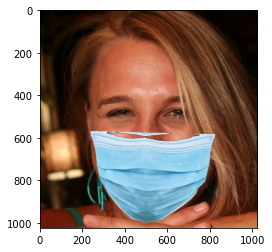

In [6]:
img_array = cv2.imread("../input/facemask-facenet/mask/00001_Mask.jpg")
plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))

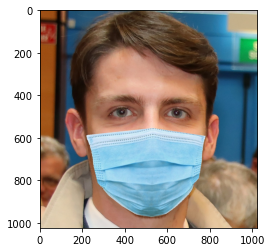

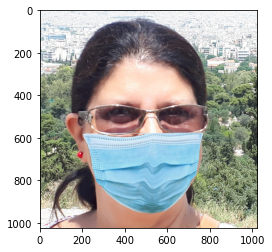

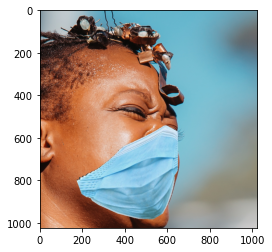

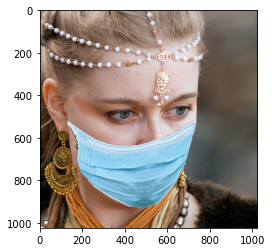

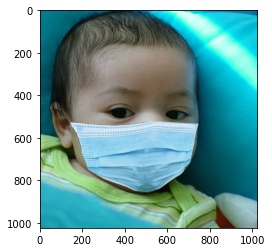

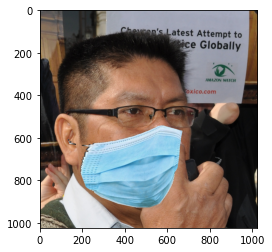

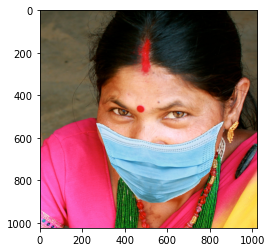

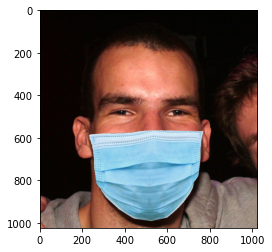

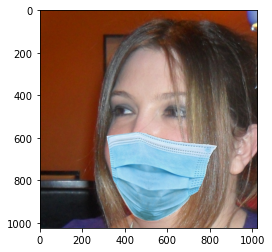

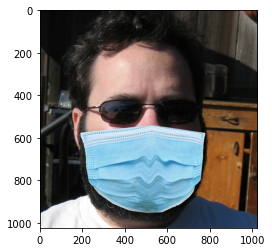

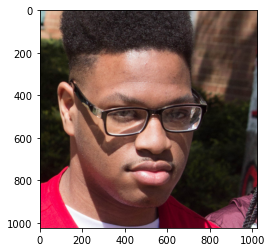

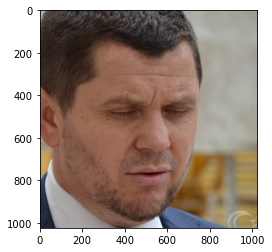

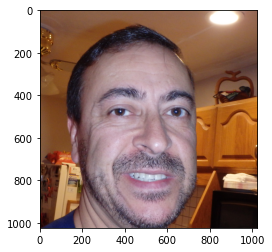

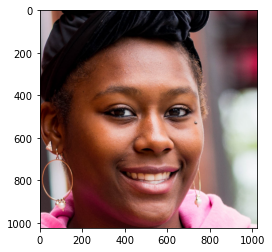

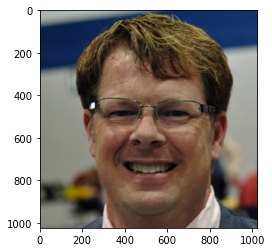

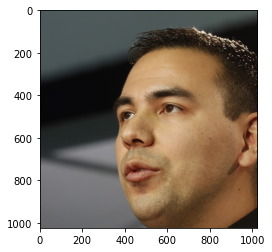

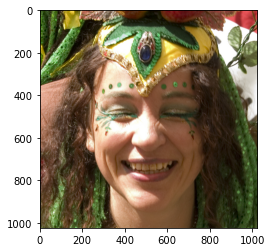

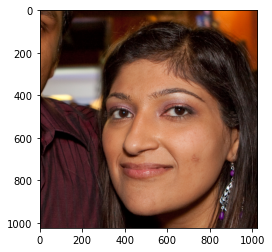

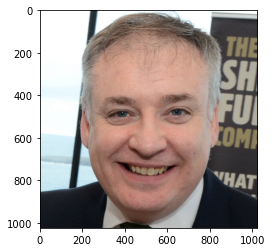

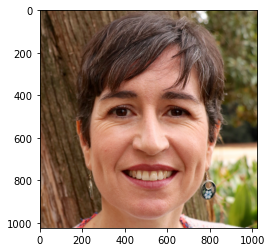

In [8]:
DIR = '../input/facemask-facenet'
classes = ['mask','no mask']
counter = 0
for cat in classes:
    counter = 0
    path = os.path.join(DIR,cat)
    for img in os.listdir(path):
        img=cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.show()
        counter+=1
        if counter == 10:
            break
        

In [9]:
#Resizing image to 224x224 for transfer learning 

img_size = 224

train = []

def create_train():
    for cat in classes:
        path = os.path.join(DIR,cat)
        class_num = classes.index(cat) # 0 and 1 label
        for img in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path,img))
                new_img = cv2.resize(img,(img_size,img_size))
                train.append([new_img,class_num])
            except Exception as e:
                pass

In [10]:
create_train()

In [11]:
print(len(train))

3082


In [12]:
#Shuffle data
import random
random.shuffle(train)

In [25]:
X = [] #data
y = []#label
for features,label in train:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1,img_size,img_size,3) #-1 all the size of images

#Normalise the data
X=X/255.0
Y=np.array(y)

In [14]:
#Deep learning - Transfer learning

from tensorflow import keras
from tensorflow.keras import layers

In [16]:
model = tf.keras.applications.mobilenet.MobileNet() #pretrained model

17227776/17225924 [==============================] - 0s 0us/step


In [17]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [19]:
#Now we try to remove the head and add our own Fully connected and final layer
base_input = model.layers[0].input
base_output = model.layers[-4].output

In [21]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer)
final_output = layers.Activation('sigmoid')(final_output)
new_model = keras.Model(inputs = base_input,outputs = final_output)
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [23]:
#Classification training
new_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [26]:
new_model.fit(X,Y,epochs=20,validation_split=0.2)

Epoch 1/20
78/78 [==============================] - 13s 165ms/step - loss: 0.0238 - accuracy: 0.9915 - val_loss: 0.6063 - val_accuracy: 0.9060
Epoch 2/20
78/78 [==============================] - 12s 153ms/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.0041 - val_accuracy: 0.9984
Epoch 3/20
78/78 [==============================] - 12s 150ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 4.9597e-08 - val_accuracy: 1.0000
Epoch 4/20
78/78 [==============================] - 12s 153ms/step - loss: 0.0014 - accuracy: 0.9992 - val_loss: 1.4896e-07 - val_accuracy: 1.0000
Epoch 5/20
78/78 [==============================] - 12s 152ms/step - loss: 0.0301 - accuracy: 0.9943 - val_loss: 47.3446 - val_accuracy: 0.3323
Epoch 6/20
78/78 [==============================] - 12s 151ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.3437 - val_accuracy: 0.9514
Epoch 7/20
78/78 [==============================] - 12s 153ms/step - loss: 1.2657e-04 - accuracy: 1.0000 - val_loss: 0.0056 - val_acc

In [27]:
new_model.save('face_mask.h5')

In [ ]:
#Checking for predictions
prediction_model = tf.keras.models.load_model('./face_mask.h5')